In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder
from ATARI.utils.stats import chi2_val

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [2]:
%matplotlib widget

In [3]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


spin_groups = [ (3.0,1,0) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/TestFMReduction.hdf5'
dataset_range = (0, 10)
samples_not_generated = generate(Ta_pair, exp, 
                                        'syndat_SLBW', 
                                        dataset_range, 
                                        case_file,
                                        fixed_resonance_ladder=None, 
                                        open_data=None,
                                        vary_Erange=None,
                                        use_hdf5=True,
                                        overwrite = False
                                                                    )

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


<ErrorbarContainer object of 3 artists>

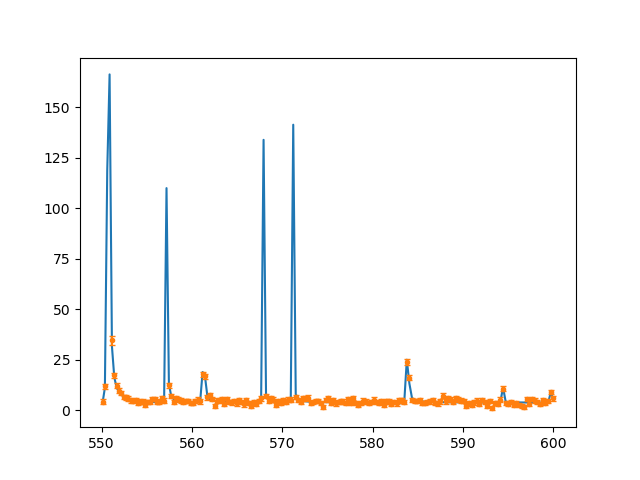

In [4]:
import ATARI.atari_io.hdf5 as io
from ATARI.utils.misc import fine_egrid 
from ATARI.utils.io.datacontainer import DataContainer
from ATARI.utils.io.pointwise import PointwiseContainer
from ATARI.utils.io.parameters import TheoreticalParameters, ExperimentalParameters


# read hdf
casenum = 3
theo_resladder = pd.read_hdf(case_file, f'sample_{casenum}/theo_par')
exp_pw, exp_cov = io.read_experimental(case_file, casenum)


threshold_0T = 1e-2
exp_par = ExperimentalParameters(0.067166, 0, threshold_0T)
theo_par = TheoreticalParameters(Ta_pair, theo_resladder)
est_par = TheoreticalParameters(Ta_pair, theo_resladder)

pwfine = pd.DataFrame({'E':fine_egrid(exp_pw.E,100)})
pw = PointwiseContainer(exp_pw, pwfine)
pw.add_experimental(exp_pw, exp_cov, exp_par)
pw.add_model(theo_par, exp_par, 'theo')


dc = DataContainer(pw, exp_par, theo_par)

figure()
# plot(pw.fine.E, pw.fine.theo_xs)
plot(dc.pw.exp.E, dc.pw.exp.theo_xs)
errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.')
# ylim([-max_xs*.1, max_xs*1.25])


## Class Setup

In [5]:
from dataclasses import dataclass
from typing import Optional

def get_resonance_ladder_from_feature_pairs(weights, feature_pairs):
    Elam = feature_pairs[:,0]
    Gt = feature_pairs[:,1]*1e3
    Gnx = Gt*weights
    Gg = Gt-Gnx
    resonances = np.array([Elam, Gt, Gnx, Gg, weights])
    resonance_ladder = pd.DataFrame(resonances.T, columns=['E', 'Gt', 'Gnx', 'Gg', 'w'])
    return resonance_ladder

@dataclass
class FeatureBank:
    feature_matrix: np.ndarray
    feature_pairs: np.ndarray
    potential_scattering: np.ndarray
    nfeatures: int
    solution_ws: Optional[np.ndarray] = None

    @property
    def model(self):
        return self.feature_matrix@self.solution_ws+self.potential_scattering
    
    def get_parameter_solution(self):
        return get_resonance_ladder_from_feature_pairs(self.solution_ws, self.feature_pairs)

@dataclass
class MatrixInputs:
    P: np.ndarray
    q: np.ndarray
    G: np.ndarray
    h: np.ndarray
    lb: np.ndarray
    ub: np.ndarray
    index_0T: np.ndarray
    
@dataclass
class QPopt:
    solver: str = "cvxopt"
    verbose: bool = False
    abstol: float = 1e-12
    reltol: float = 1e-12
    feastol: float = 1e-8
    maxiters: float =  100


class Solvers:

    @staticmethod
    def solve_quadratic_program(inputs: MatrixInputs, qpopt: QPopt) -> Optional[np.ndarray] :

        sol_w = solve_qp(inputs.P, inputs.q, G=inputs.G, h=inputs.h, A=None, b=None, lb=inputs.lb, ub=inputs.ub, 
                                                                                                    solver=qpopt.solver,
                                                                                                    verbose=qpopt.verbose,
                                                                                                    abstol=qpopt.abstol,
                                                                                                    reltol=qpopt.reltol,
                                                                                                    feastol=qpopt.feastol,
                                                                                                    maxiters=qpopt.maxiters
                                                                                                    )
        return sol_w
    
    @staticmethod
    def solve_linear_program(inputs):
        sol_w = linprog(inputs.q, A_ub=inputs.G, b_ub=inputs.h, bounds=np.array([inputs.lb, inputs.ub]).T)
        return sol_w.x
        

class ProblemHandler:

    def __init__(self, w_threshold):
        self.w_threshold = w_threshold
        

    def get_FeatureBank(self, dc: DataContainer, ElFeatures:np.ndarray, GtFeatures: np.ndarray):

        feature_matrix, potential_scattering, feature_pairs = fn.get_resonance_feature_bank(dc.pw.exp.E, dc.theo_par.particle_pair, ElFeatures, GtFeatures)
        nfeatures = np.shape(feature_matrix)[1]

        return FeatureBank(feature_matrix, feature_pairs, potential_scattering.flatten(), nfeatures)


    def get_MatrixInputs(self, dc: DataContainer, feature_bank: FeatureBank):
        P, q, G, h, lb, ub, index_0T =  fn.get_qp_inputs(np.array(dc.pw.exp.E), np.array(dc.pw.exp.exp_xs), np.array(dc.pw.CovXS), 
                                                feature_bank.potential_scattering, dc.exp_par.max_xs, feature_bank.feature_matrix, feature_bank.feature_pairs, dc.theo_par.particle_pair)
        return MatrixInputs(P, q, G, h, lb, ub, index_0T)
    

    def get_ConstrainedMatrixInputs(self, dc:DataContainer, feature_bank: FeatureBank, w_constraint: float):
        P, q, G, h, lb, ub, index_0T =  fn.get_qp_inputs(np.array(dc.pw.exp.E), np.array(dc.pw.exp.exp_xs), np.array(dc.pw.CovXS), 
                                                feature_bank.potential_scattering, dc.exp_par.max_xs, feature_bank.feature_matrix, feature_bank.feature_pairs, dc.theo_par.particle_pair)
        G_wc = np.vstack([G,np.ones(len(P))])
        h_wc = np.append(h, w_constraint)
        return MatrixInputs(P, q, G_wc, h_wc, lb, ub, index_0T)


    def get_MinSolvableWeight(self, nfeatures: int, inputs: MatrixInputs):
        c = np.ones(nfeatures)
        lp_minw_unred = linprog(c, A_ub=inputs.G, b_ub=inputs.h, bounds=np.array([inputs.lb, inputs.ub]).T)
        return np.sum(lp_minw_unred.x)


    def reduce_FeatureBank(self, bank: FeatureBank, sol_w: np.ndarray):
        feature_matrix, feature_pairs, reduced_solw = fn.get_reduced_features(bank.feature_matrix, sol_w, self.w_threshold, bank.feature_pairs)
        nfeatures = np.shape(feature_matrix)[1]
        return FeatureBank(feature_matrix, feature_pairs, bank.potential_scattering, nfeatures), reduced_solw



## Approach

0. Solve initial and reduce feature bank (don't want to do this step but I am for now to speed up computation)

1. Solve unconstrained problem with 'full' feature bank. 

2. Run bisection routine to get solutions constrained to different number of features (Resonances)
    a. Maximum possible weight comes from 1.
    b. Solve for the minimum possible weight constraint using LP. 

3. For each solution corresponding to an integer number of features, reduce the feature bank and solve the unconstrained problem

4. For each solution from 3 as a prior, solve the GLLS problem to search the constinuous parameter space

5. Perform LRT between the models from 4

## Step 0, reduce initial feature bank for computational speed

In [6]:
### Step 0
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e0, 1e0)
Gtot_features = np.round(np.array(theo_resladder.Gt),1)*1e-3
Elam_features = np.append(Elam_features, np.round(np.array(theo_resladder.E),1))
# Elam_features = np.round(np.array(theo_resladder.E),1)

w_threshold = 1e-10
prob = ProblemHandler(w_threshold)

fb0 = prob.get_FeatureBank(dc, Elam_features, Gtot_features)
inp0 = prob.get_MatrixInputs(dc, fb0)

sol_lp0 = Solvers.solve_linear_program(inp0)

## Step 1, solve unconstrained problem

In [7]:
qpopt = QPopt()

In [8]:
### Step 1
# fb1, sol_lp0_ereduced = prob.reduce_FeatureBank(fb0, sol_lp0)
# inp1 = prob.gt_MatrixInputs(dc, fb1)
fb1 = fb0
inp1 = inp0
fb1.solution_ws = Solvers.solve_quadratic_program(inp1, qpopt)
# print(fb1.nfeatures)

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


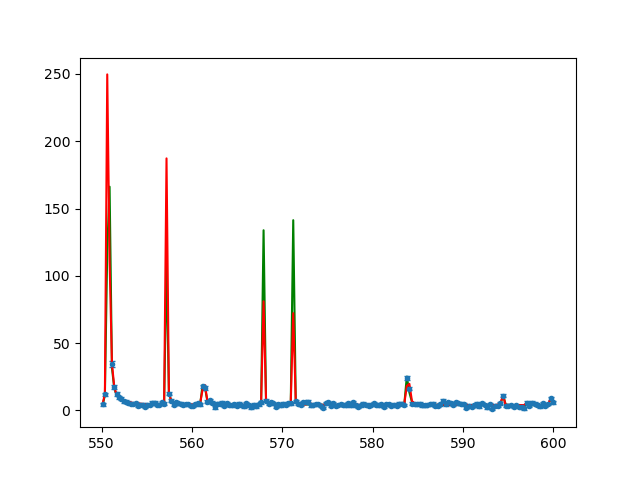

In [9]:
figure()
plot(dc.pw.exp.E, dc.pw.exp.theo_xs, 'g')
errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
plot(dc.pw.exp.E, fb1.model, 'r')

In [10]:
def solve_qp_w_constraint(dc, fb, wcon, qpopt: QPopt):
    inp = prob.get_ConstrainedMatrixInputs(dc, fb, wcon)
    sol = Solvers.solve_quadratic_program(inp, qpopt)
    return sol

## Step 2, run bisection routine

In [11]:
### Bisection Routine
def bisect(x0,x1):
    return (x0+x1)/2

def bisect_and_solve(current_target_ires, minval, maxval, target_numres, wcon, sol_ws, save_all, searching=True, termination_threshold=1e-3):

    icurrent_target_ires = current_target_ires-min(target_numres)
    
    while searching:

        # check termination criteria
        if abs((minval-maxval)/maxval) < termination_threshold:
            searching = False
        elif wcon[icurrent_target_ires] > 0:
            searching = False

        # bisect, solve, and save result
        new_w = bisect(minval, maxval)
        con_sol_ws = solve_qp_w_constraint(dc, fb1, new_w, qpopt) # TODO: Make dc and fb dynamic here!
        if con_sol_ws is None:
            wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, new_w, maxval, target_numres, wcon, sol_ws, save_all, searching=searching)
        else:
            numres_sol = np.count_nonzero(con_sol_ws>w_threshold)
            ires_sol = numres_sol-min(target_numres)
            save_all.append((new_w, numres_sol))

            if numres_sol == current_target_ires:
                #record if current target
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws

            elif numres_sol > current_target_ires:
                # record other if in target numres
                if numres_sol in target_numres:
                    if wcon[ires_sol] < new_w:
                        wcon[ires_sol] = new_w
                        sol_ws[:,ires_sol] = con_sol_ws
                # bisect again to find current target
                wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, minval, new_w, target_numres, wcon, sol_ws, save_all, searching=searching)

            elif numres_sol < current_target_ires:
                # record other if in target numres
                if numres_sol in target_numres:
                    if wcon[ires_sol] < new_w:
                        wcon[ires_sol] = new_w
                        sol_ws[:,ires_sol] = con_sol_ws
                # bisect again to find current target
                wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, new_w, maxval, target_numres, wcon, sol_ws, save_all, searching=searching)

    return wcon, sol_ws, save_all, searching

def get_bounding_wcons(ires_target, save_all):
    temp = np.array(save_all)
    temp = temp[temp[:,0].argsort()]
    index = np.searchsorted(temp[:,1], ires_target, side='right')
    return temp[index-1,0], temp[index,0]

def get_target_numres_array(target_maxres, max_numres, min_numres):
    return np.arange(min_numres, np.min([target_maxres,max_numres]), 1)

def get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, target_wcon=None, sol_ws = None):
    if target_wcon is None and sol_ws is None:
        target_wcon = np.zeros(len(target_numres))
        if min_wcon == 0:
            min_wcon = 1e-10
        target_wcon[0] = min_wcon
        sol_ws = np.zeros((len(min_wcon_solw), len(target_numres)))
        sol_ws[:, 0] = min_wcon_solw
    elif target_wcon is None or sol_ws is None:
        raise ValueError("Either target_wcon or sol_ws is None while the other is populated, check input.")
    else:
        elements_to_add = len(target_numres)-len(target_wcon)
        assert elements_to_add >= 0, "target_numres is shorter than target_wcon"
        target_wcon = np.append(target_wcon, [0]*elements_to_add)
        sol_ws = np.append(sol_ws, np.zeros((np.shape(sol_ws)[0], elements_to_add)), axis=1)
    return target_wcon, sol_ws

In [12]:
### Step 2

# determine mins and maxes
min_wcon = prob.get_MinSolvableWeight(fb1.nfeatures, inp1)
max_wcon = np.sum(fb1.solution_ws)
max_numres = np.count_nonzero(fb1.solution_ws>w_threshold)
min_wcon_solw = solve_qp_w_constraint(dc, fb1, min_wcon*1.0001, qpopt)
min_numres = np.count_nonzero(min_wcon_solw>w_threshold)

# determine targets
target_numres = get_target_numres_array(25, max_numres, min_numres)
target_wcon, target_sol_ws = get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, target_wcon=None, sol_ws=None)
save_all = [(min_wcon, min_numres), (max_wcon, max_numres)]

print(target_numres)
print(target_wcon)

# Run bisection routine
for current_target_ires in target_numres[::-1]:
    print(f'Found: {target_numres[target_wcon!=0]}')
    print(f'Current target: {current_target_ires}')
    minwcon, maxwcon = get_bounding_wcons(current_target_ires, save_all)
    target_wcon, target_sol_ws, save_all, _ = bisect_and_solve(current_target_ires,
                                                                minwcon, maxwcon,
                                                                target_numres, target_wcon, target_sol_ws, save_all)

print(target_numres)
print(target_wcon)

[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[0.36092167 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Found: [7]
Current target: 24
Found: [ 7 16 18 24]
Current target: 23
Found: [ 7 16 18 22 24]
Current target: 22
Found: [ 7 16 18 22 24]
Current target: 21
Found: [ 7 16 18 20 21 22 24]
Current target: 20
Found: [ 7 16 18 20 21 22 24]
Current target: 19
Found: [ 7 16 18 19 20 21 22 24]
Current target: 18
Found: [ 7 16 18 19 20 21 22 24]
Current target: 17
Found: [ 7 16 17 18 19 20 21 22 24]
Current target: 16
Found: [ 7 16 17 18 19 20 21 22 24]
Current target: 15
Found: [ 7 12 13 14 15 16 17 18 19 20 21 22 24]
Current target: 14
Found: [ 7 12 13 14 15 16 17 18 19 20 21 22 24]
Current target: 13
Found: [ 7 12 13 14 15 16 17 18 19 20 21 22 24]
Current target: 12
Found: [ 7 12 13 14 15 16 17 18 19 20 21 22 24]
Current target: 11
Found: [ 7 12 13 14 15

## Step 3, Solve reduced, unconstrained solution for each integer number of resonances

In [13]:
integer_feature_solutions = {key: FeatureBank for key in target_numres[target_wcon!=0]}

chi2pairs = []

for numres in target_numres[target_wcon!=0]:
    
    inumres = numres-min(target_numres)

    # constrained unreduced
    constrained_solution = target_sol_ws[:, inumres]

    fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
    inp3 = prob.get_MatrixInputs(dc, fb3)
    fb3.solution_ws = Solvers.solve_quadratic_program(inp3, qpopt)

    integer_feature_solutions[numres] = fb3

    # chi2 = chi2_val(fb3.model, dc.pw.exp.exp_xs, dc.pw.CovXS)
    # chi2pairs.append((numres, chi2))

    Pchi2 = (1/2)* fb3.solution_ws.T@inp3.P@fb3.solution_ws + inp3.q.T@fb3.solution_ws
    chi2pairs.append((numres, Pchi2))
    
chi2pairs

[(7, -267.91068185124044),
 (8, -322.7393611492797),
 (9, -431.4936367799956),
 (10, -433.3512961338745),
 (12, -506.17977959599006),
 (13, -518.8167864162871),
 (14, -520.3486545296571),
 (15, -522.6179771483858),
 (16, -523.9106661335055),
 (17, -524.3169679590889),
 (18, -525.4933354194554),
 (19, -526.0254532430911),
 (20, -526.025453243091),
 (21, -526.2254364093247),
 (22, -527.2803860280031),
 (24, -527.6875020204814)]

### How should I combine widths and weights if I have resonances very close to one another?

You cannot exactly calculate a w3 from (w1, w2) at the same energy location. I would like to approximate the combination of resonances that have very similar Elambda locations. The objective for the combination is to minimize the L2 norm between SLBW(w3) and SLBW(w2)+SLBW(w1) where w3 is some function of w2 and w1.

In [14]:
### Trying to minimize difference between combined features at one energy and multiple features near one another

before_res = ires_resladder.loc[12:14,:]
print(before_res)

# E = fine_egrid(dc.pw.exp.E, ppeV=100)
E = dc.pw.exp.E
before, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(before_res, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) ) #%


Resonance_Matrix, potential_scattering, feature_pairs = fn.get_resonance_feature_bank(E, Ta_pair, [np.mean(before_res['E'].unique())], before_res['Gt'].unique()*1e-3)
Ptest = Resonance_Matrix.T @ np.diag(np.ones(len(before))) @ Resonance_Matrix
qtest =  - Resonance_Matrix.T @ np.diag(np.ones(len(before))) @ (dc.pw.exp.E-potential_scattering).flatten() 

lb, ub = np.ones(1)*0, np.ones(1)*1
# test = linprog(qtest, bounds=np.array([lb, ub]).T)
test = solve_qp(Ptest, qtest, G=None, h=None, A=None, b=None, lb=lb, ub=ub, 
                                                                solver=qpopt.solver,
                                                                verbose=True, #qpopt.verbose,
                                                                abstol=qpopt.abstol,
                                                                reltol=qpopt.reltol,
                                                                feastol=qpopt.feastol,
                                                                maxiters=qpopt.maxiters
                                                                )
    
# print(test)

figure()
plot(dc.pw.exp.E, dc.pw.exp.exp_xs, '.k')
plot(E, (before-potential_scattering).flatten(), 'r')
plot(E, Resonance_Matrix@test)
# plot(E, Resonance_Matrix)


# combined, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )

NameError: name 'ires_resladder' is not defined

In [ ]:
## Test combining features
numres = 22
ires_featurebank = integer_feature_solutions[numres]
ires_resladder = ires_featurebank.get_parameter_solution()
print(ires_resladder)


# ires_resladder_combined = ires_resladder.groupby('E').agg({'Gt':'sum', 'Gnx':'sum', 'Gg':'sum', 'w':'sum'}).reset_index()

### to just combine if E are the exact same
def calculate_combined_parameters(x):
    if len(x) == 1:
        return x #[['Gt', 'Gnx', 'Gg', 'w']]
    else:
        Gnx = (x['w']*x['Gt']).sum()
        Gt = (x['w']*x['Gt']**2).sum() / Gnx
        w = Gnx/Gt
        Gg = Gt-Gnx
    return pd.DataFrame({'E':x['E'].unique(), 'Gt':Gt, 'Gnx':Gnx, 'Gg':Gg, 'w':w}, index=[0]) # pd.DataFrame({'Gt':Gt, 'Gnx':Gnx, 'Gg':Gg, 'w':w}, index=[0])
    
ires_resladder_combined = ires_resladder.groupby(ires_resladder['E'], group_keys=False).apply(calculate_combined_parameters).reset_index(drop=True)



### to combine with weighted average on E if they are close
# def weighted_avg(x):
#     return (x['E'] * x['w']).sum() / x['w'].sum()

# threshold = 1
# ires_resladder_combined = (
#     ires_resladder.groupby(ires_resladder['E'].diff().abs().gt(threshold).cumsum())
#     .apply(lambda x: pd.Series([weighted_avg(x), x['Gt'].sum(), x['Gnx'].sum(), x['Gg'].sum(), x['w'].sum()], index=['E','Gt', 'Gnx','Gg','w'] )) 
#     .reset_index(drop=True)
# )

# # new_numres = len(ires_resladder_combined)
print(ires_resladder_combined)

             E     Gt           Gnx          Gg             w
0   550.993229  112.5  4.346655e+00  108.153345  3.863693e-02
1   551.993229  112.5  2.232133e-01  112.276787  1.984119e-03
2   552.993229  112.5  8.734219e-10  112.500000  7.763750e-12
3   561.993229  112.5  1.420193e-01  112.357981  1.262394e-03
4   562.993229  112.5  6.187095e-02  112.438129  5.499640e-04
5   565.993229  112.5  8.144435e-02  112.418556  7.239497e-04
6   568.993229  112.5  5.106689e-02  112.448933  4.539279e-04
7   574.993229  112.5  3.165906e-01  112.183409  2.814139e-03
8   578.993229  112.5  6.378711e-02  112.436213  5.669965e-04
9   579.993229  112.5  3.208096e-01  112.179190  2.851641e-03
10  582.993229  112.5  2.269368e-01  112.273063  2.017216e-03
11  596.993229  112.5  1.921917e-01  112.307808  1.708371e-03
12  597.993229  112.5  1.440614e-01  112.355939  1.280546e-03
13  550.700000  112.5  3.989018e+01   72.609825  3.545793e-01
14  557.200000  112.5  6.295153e+00  106.204847  5.595691e-02
15  561.

In [ ]:
## Plotting combined features
numres = 22
# numres_other = 9
rxn = 'xs'
E = fine_egrid(dc.pw.exp.E, ppeV=1000)
before, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )
combined, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )

figure()
plot(dc.pw.fine.E, dc.pw.fine[f'theo_{rxn}'], 'g', lw=5)
plot(dc.pw.exp.E, dc.pw.exp[f'exp_{rxn}'], '.k')

plot(E, before, 'b', lw=2)
plot(E, combined, 'r', lw=1)
# # plot(dc.pw.exp.E, integer_feature_solutions[numres_other].model, 'b', lw=2)
# plot(dc.pw.exp.E, integer_feature_solutions[numres].model, 'r', lw=1)

In [ ]:
### Here's where I handle resonances at the same energies and those with weights very small
integer_resonance_solutions = {}
for numres in target_numres[target_wcon!=0]:
    ires_featurebank = integer_feature_solutions[numres]
    ires_resladder = ires_featurebank.get_parameter_solution()

    ires_resladder_combined = ires_resladder.groupby(ires_resladder['E'], group_keys=False).apply(calculate_combined_parameters).reset_index(drop=True)
    ires_resladder_combined = ires_resladder_combined.drop(ires_resladder_combined[ires_resladder_combined['w'] < prob.w_threshold].index)
    new_numres = len(ires_resladder_combined)

    ires_resladder_combined = fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)
    integer_resonance_solutions[new_numres] = {'prior':ires_resladder_combined}

    # add prior to dc
    est_par = TheoreticalParameters(Ta_pair, ires_resladder_combined)
    dc.add_estimate(est_par, label=f'{new_numres}_prior')

integer_resonance_solutions.keys()

dict_keys([6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22])

In [ ]:
# numres = 12
# numres_other = 9
# rxn = 'xs'

# figure()
# plot(dc.pw.exp.E, dc.pw.exp[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dc.pw.exp[f'exp_{rxn}'], '.k')
# # plot(dc.pw.exp.E, dc.pw.exp[f'{numres_other}_{rxn}'], 'b', lw=2)
# # plot(dc.pw.exp.E, dc.pw.exp[f'{numres}_{rxn}'], 'r', lw=1)
# # plot(dc.pw.exp.E, integer_feature_solutions[numres_other].model, 'b', lw=2)
# plot(dc.pw.exp.E, integer_feature_solutions[numres].model, 'r', lw=1)

## Step 4, run GLLS on transmission with reduced, unconstrained solution from 3 as prior

In [ ]:
from ATARI.sammy_interface import sammy_functions, sammy_classes
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'transmission',
    solve_bayes = True,
    experimental_corrections = 'no_exp',
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = True,
    one_spingroup = True,
    energy_window = None 
    )

In [ ]:
integer_resonance_solutions.keys()

dict_keys([6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22])

In [ ]:
### Run GLLS
for numres in integer_resonance_solutions.keys():
    if numres == 0:
        continue
    prior = integer_resonance_solutions[numres]['prior']
    
    sammyINP = sammy_classes.SammyInputData(
        particle_pair = Ta_pair,
        resonance_ladder = prior, 
        experimental_data = dc.pw.exp, 
        experimental_cov = dc.pw.CovT, 
    )

    lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
    ## if posterior is worse than prior, re-run
    posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)
    integer_resonance_solutions[numres]['posterior'] = posterior

    est_par = TheoreticalParameters(Ta_pair, posterior)
    dc.add_estimate(est_par, label=f'{numres}_post')

In [ ]:
### Calculate Chi2 on trans
[ (chi2_val(dc.pw.exp[f'{numres}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT), numres) for numres in dc.est_par.keys()]

[(1968.8531783529147, 7),
 (1009.7575682720608, 8),
 (298.51518803600703, 9),
 (293.0917308960007, 10),
 (1895.5059511973589, '6_prior'),
 (1525.2150379123082, '7_prior'),
 (948.6242728947784, '8_prior'),
 (944.3290633792575, '9_prior'),
 (241.87656721760405, '10_prior'),
 (238.7726816683354, '12_prior'),
 (233.3629111254593, '13_prior'),
 (230.21184903329896, '14_prior'),
 (229.29258265979087, '15_prior'),
 (226.5210630396213, '17_prior'),
 (225.3721093564607, '18_prior'),
 (224.92749590889895, '19_prior'),
 (222.4535848152806, '20_prior'),
 (221.6131588698667, '22_prior'),
 (1964.6304935958838, '6_post'),
 (1020.6237552992869, '7_post'),
 (298.8569285400697, '8_post'),
 (293.2301591047785, '9_post'),
 (396.2590358329012, '10_post'),
 (194.1402168452598, '12_post'),
 (209.33857681752588, '13_post'),
 (320.6791108172402, '14_post'),
 (448.4894258935768, '15_post'),
 (459.3396677158763, '17_post'),
 (474.1804141003081, '18_post'),
 (226.00757844046097, '19_post'),
 (459.2335279878211, '

In [ ]:
### Interrogate

# print(dc.est_par['21_prior'].resonance_ladder[['E','Gt','Gnx','Gg','w']])
# print(dc.est_par['22_prior'].resonance_ladder[['E','Gt','Gnx','Gg','w']])

# rxn = 'trans'
# less = dc.pw.exp[f'21_prior_{rxn}']
# more = dc.pw.exp[f'22_prior_{rxn}']

# dat =dc.pw.exp[f'exp_{rxn}']
# figure()
# # plot(dc.pw.exp.E, dc.pw.exp[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dat, '.k')
# plot(dc.pw.exp.E, less, 'b', lw=2)
# plot(dc.pw.exp.E, more, 'r', lw=1)

# # plot(dc.pw.exp.E, (less-dat)**2, 'b', lw=2)
# # plot(dc.pw.exp.E, (more-dat)**2, 'r', lw=1)

# # print(chi2_val(a, b, np.array(dc.pw.CovT)))
# print(np.sum((less-dat)**2))
# # print(chi2_val(a1, b, np.array(dc.pw.CovT)))
# print(np.sum((more-dat)**2))

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
0    556.479440
1    562.302018
2    573.014271
3    578.148865
4    588.438550
5    595.084907
Name: E, dtype: float64
0    552.997309
4    562.295781
1    571.990801
5    578.099449
2    592.994729
3    595.016320
Name: E, dtype: float64


In [ ]:
### Interrogate some more

# numres = 5
# inumres = numres-min(target_numres)

# # constrained unreduced
# constrained_solution = target_sol_ws[:, inumres]

# fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
# inp3 = prob.get_MatrixInputs(dc, fb3)
# fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

# prior = fb3.get_parameter_solution()
# prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# sammyINP = sammy_classes.SammyInputData(
#     particle_pair = Ta_pair,
#     resonance_ladder = prior, 
#     experimental_data = dc.pw.exp, 
#     experimental_cov = dc.pw.CovT, 
# )

# lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
# posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# print(chi2_val(lst.theo_trans, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(chi2_val(lst.theo_trans_bayes, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(prior[['E','Gt','Gnx']])
# print(posterior[['E','Gt','Gnx']])

In [ ]:
### Run individual bayes


# numres = 9
# inumres = numres-min(target_numres)

# constrained_solution = target_sol_ws[:, inumres]

# fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
# inp3 = prob.get_MatrixInputs(dc, fb3)
# fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

# prior = fb3.get_parameter_solution()
# prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# sammyINP = sammy_classes.SammyInputData(
#     particle_pair = Ta_pair,
#     resonance_ladder = prior, 
#     experimental_data = dc.pw.exp, 
#     experimental_cov = dc.pw.CovT, 
# )

# lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
# posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# print(chi2_val(lst.theo_trans, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(chi2_val(lst.theo_trans_bayes, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(prior[['E','Gt','Gnx']])
# print(posterior[['E','Gt','Gnx']])

## Step 5, Likelihood ratio test on each of the posterior solutions to determine which number of resonances we should have

In [ ]:
# [ (chi2_val(dc.pw.exp[f'{numres}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT), numres) for numres in dc.est_par.keys()]

post_ires_keys = [[float(key.split('_')[0]),key] for key in dc.est_par.keys() if key.split('_')[1]=='post']
post_ires_keys

AttributeError: 'numpy.int64' object has no attribute 'split'

In [ ]:
import numpy as np
from scipy.stats import chi2

def likelihood_ratio_test(X2_null, X2_alt, df):
    """
    Perform a likelihood ratio test for nested models.

    Args:
        llmin: Log-likelihood of the null (restricted) model.
        llmax: Log-likelihood of the alternative (unrestricted) model.
        df: Degrees of freedom difference between the two models.

    Returns:
        lrt_stat: Likelihood ratio test statistic.
        p_value: p-value associated with the test statistic.
    """
    # lrt_stat = 2 * (llmax - llmin)
    lrt_stat = X2_null - X2_alt
    p_value = 1 - chi2.cdf(lrt_stat, df)
    return lrt_stat, p_value

# Log-likelihood values for each model
# ll_values = [ll_model1, ll_model2, ll_model3, ...]  # Replace with your own log-likelihoods
# num_parameters = [params_model1, params_model2, params_model3, ...]  # Number of parameters in each model

best_model = None
best_num_params = 0
best_lrt_stat = 0.0
best_p_value = 1.0

# Loop through each model and perform likelihood ratio tests
for ires, key in post_ires_keys[1::]:

    print(key)
    # df = num_parameters[i] - num_parameters[i - 1]  # Degrees of freedom difference between the two models

#     lrt_stat, p_value = likelihood_ratio_test(llmin, llmax, df)

#     print(f"Model {i - 1} vs. Model {i}:")
#     print(f"Likelihood ratio test statistic: {lrt_stat}")
#     print(f"P-value: {p_value}")

#     # Update the best model based on the p-value
#     if p_value < 0.05 and lrt_stat > best_lrt_stat:
#         best_model = i
#         best_num_params = num_parameters[i]
#         best_lrt_stat = lrt_stat
#         best_p_value = p_value

# print(f"Best model: Model {best_model} with {best_num_params} parameters")

NameError: name 'post_ires_keys' is not defined

## Notes

#### Initial uncertainty on parameters in sammy
should be large, we don't have a prior we just want the GLLS to converge.

Fudge factor cant be too larger for numerics:
 - M' = (M^-1 + (G.T @ V^-1 @ G.T) )^-1
 - first term is full rank, second is not guranteed (it is if NEpts>=NPar). Becasue the first term is full rank, then adding it to the second makes the whole thing full rank and therefore invertable. However, if the first term (M^-1 or 1/prior variance) is driven numerically to 0, then you are left with only the second term. If it is not full rank it won't be invertable then the thing will not be numerically stable. 

#### Sammy is not always converging
- could run sammy multiple times?
- also, the problem is resolved when I 'cheat' with the resonance energies. I think having multiple small resonances right on top of one another is causing sammy to run away.


#### Unexpected behavior when finding integer number of resonances
Often times the weight constrained solution for an integer number of resonances will have selected a smaller resonance than expected when there's a larger existing resonance that would drive the chi2 even lower. I believe this is a problem with not finding the maximum weight solution to an integer number of resonances.